## Imports and global variables

In [248]:
import os
import re
import pandas as pd
import numpy as np
import torch

In [249]:
TIMESTAMPS_PATH = 'train/train/scene_timestamps'
FEATURES_PATH = 'train/train/features'
LABELS_PATH = 'train/train/labels'
SUBTITLES_PATH = 'train/train/subtitles'

TEST_TIMESTAMPS_PATH = 'test/test/scene_timestamps'
TEST_FEATURES_PATH = 'test/test/features'
TEST_SUBTITLES_PATH = 'test/test/subtitles'

In [250]:
# Check GPU available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Load data

### Helper functions

In [251]:
def load_files(path):
    if os.path.exists(path):
        return os.listdir(path)
    else:
        print("PATH DOES NOT EXIST!")
        return []

In [252]:
def get_movie_name(file):
    return file[10:-15]

def get_movie_id(file):
    return file[:9]

In [253]:
def get_feature_file(file):
    return file.replace("_timestamps", "")

In [254]:
def prepare_csv(path, movie_name):
    df = pd.read_csv(path)
    df.rename(columns={"Unnamed: 0": "scene_id"}, inplace=True)
    df["movie"] = movie_name
    return df

In [255]:
def extract_movie_info(files):
    movie_ids, movies = [], []
    for file in files:
        movie_name = get_movie_name(file)
        movie_id = get_movie_id(file)
        movie_ids.append(movie_id)
        movies.append(movie_name)
    return movie_ids, movies

def prepare_dataframes(files, movies, path_func, data_func):
    dfs = []
    for idx, file in enumerate(files):
        path = path_func(file)
        df = data_func(path, movies[idx])
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

def merge_dataframes(df1, df2):
    test_full_data = pd.merge(df1, df2, on=["scene_id", "movie"])
    test_full_data["end"] = test_full_data["start"] + test_full_data["s_dur"]
    return test_full_data

### Files

In [256]:
train_files = load_files(TIMESTAMPS_PATH)
# remove australia because australia subtitles are in diffrent format than everything else
train_files.remove("tt0455824_australia_timestamps.csv")

test_files = load_files(TEST_TIMESTAMPS_PATH)

### Movies

In [257]:
train_movies_ids, train_movies = extract_movie_info(train_files)
test_movies_ids, test_movies = extract_movie_info(test_files)

### Timestamps

In [258]:
train_timestamps = prepare_dataframes(
    train_files,
    train_movies,
    lambda file: os.path.join(TIMESTAMPS_PATH, file), 
    prepare_csv
)

test_timestamps = prepare_dataframes(
    test_files,
    test_movies,
    lambda file: os.path.join(TEST_TIMESTAMPS_PATH, file), 
    prepare_csv
)

### Features

In [259]:
train_features = prepare_dataframes(
    train_files,
    train_movies,
    lambda file: os.path.join(FEATURES_PATH, get_feature_file(file)), 
    prepare_csv
)

test_features = prepare_dataframes(
    test_files,
    test_movies,
    lambda file: os.path.join(TEST_FEATURES_PATH, get_feature_file(file)), 
    prepare_csv
)

### Labels

In [260]:
dfs = []
for idx, file in enumerate(train_files):
    # print(feature_files[idx])
    labels_path = os.path.join(LABELS_PATH, get_feature_file(file))
    
    df = pd.read_csv(labels_path, keep_default_na=False)
    df.rename(
        columns={
            "Unnamed: 0": "scene_id",
            "0": "label"
        }, inplace=True
    )
    df["movie"] = train_movies[idx]
    
    dfs.append(df)

train_labels = pd.concat(dfs, ignore_index=True)
# print(train_labels.shape)
# train_labels.tail()

### Merge dataframes

In [261]:
train_merged = merge_dataframes(train_timestamps, train_features)
# additionaly merge labels to train data
train_full_data = pd.merge(train_merged, train_labels, on=["scene_id", "movie"], how="outer")
print(train_full_data.shape)

test_full_data = merge_dataframes(test_timestamps, test_features)
print(test_full_data.shape)

(3729, 12)
(2470, 11)


## Join Scenes with subtitles

In [262]:
import srt

### Helper runctions

In [263]:
train_movie_scenes_count = train_full_data.groupby('movie').count()['scene_id']
print(train_movie_scenes_count)

test_movie_scenes_count = test_full_data.groupby('movie').count()['scene_id']

movie
10 things i hate about you               118
as good as it gets                       177
bad santa                                106
brokeback mountain                       154
chasing amy                               60
crash                                     97
dallas buyers club                       189
forrest gump                             124
four weddings and a funeral              144
harry potter and the sorcerer s stone    170
indiana jones and the last crusade       190
jerry maguire                            201
juno                                     102
knocked up                               193
match point                              141
meet the parents                         135
ocean s eleven                           177
one flew over the cuckoo s nest          212
pretty woman                             148
pulp fiction                             112
signs                                     81
sleepless in seattle                      93
the 

In [264]:
problematic_movies = ["the ugly truth", "the social network", "the girl with the dragon tattoo"]

In [311]:
def convert_files_to_subtitles(files):
    return [file.replace('.csv', '.srt') for file in files]

def load_subtitles(paths, movies):
    movie_subtitles = {}
    for idx, movie_name in enumerate(movies):
        # print(movie_name)
        
        if movie_name == "pretty woman":
            with open(paths[idx], 'r', encoding='utf-16') as subtitle_file:
                movie_subtitles[movie_name] = list(srt.parse(subtitle_file.read()))
        elif movie_name in problematic_movies:
            with open(paths[idx], 'r', encoding='utf-8', errors='replace') as subtitle_file:
                movie_subtitles[movie_name] = list(srt.parse(subtitle_file.read()))
        else:
            with open(paths[idx], 'r', encoding='utf-8') as subtitle_file:
                movie_subtitles[movie_name] = list(srt.parse(subtitle_file.read()))
                
    return movie_subtitles

def associate_scenes_with_subtitles(full_data, movie_subtitles):
    movies_scenes_subtitles = {}
    additional_data = []
    last_processed_subtitle_idx = 0
    missed_subtitles = 0

    for scene_idx, scene_row in full_data.iterrows():
        scene_start, scene_end = scene_row['start'], scene_row['end']
        scene_id, movie_name = scene_row['scene_id'], scene_row['movie']
        
        # Create new dictionary for every movie
        if movie_name not in movies_scenes_subtitles:
            movies_scenes_subtitles[movie_name] = {}
            last_processed_subtitle_idx = 0

        # Craete new dictionary for every scene within movie
        movies_scenes_subtitles[movie_name][scene_id] = []

        current_movie_subtitles = movie_subtitles[movie_name]
        sentence_count = 0
        for idx in range(last_processed_subtitle_idx, len(current_movie_subtitles)):
            sub = current_movie_subtitles[idx]
            sub_start, sub_end = sub.start.total_seconds(), sub.end.total_seconds()

            # Some subtitles start just before scene_start
            if scene_start <= (sub_start + 0.05) and scene_end >= sub_end:
                # Add subtitle content to the dictionary for the current scene
                movies_scenes_subtitles[movie_name][scene_id].append(sub.content)
                sentence_count += sub.content.count('.') + sub.content.count('!') + sub.content.count('?')
            elif scene_end < sub_end:
                last_processed_subtitle_idx = idx
                break
            else:
                missed_subtitles += 1
        
        additional_data.append({
            'movie': movie_name,
            'scene_id': scene_id,
            'sentence_count': sentence_count,
        })

    print(f"Ignored subtitltes: {missed_subtitles}")
    additional_df = pd.DataFrame(additional_data)
    return movies_scenes_subtitles, additional_df


def associate_scenes_with_subtitles_extra_info(full_data, movie_subtitles, movie_scenes_count):
    movies_scenes_subtitles = {}
    last_processed_subtitle_idx = 0
    missed_subtitles = 0

    for scene_idx, scene_row in full_data.iterrows():
        scene_start, scene_end = scene_row['start'], scene_row['end']
        scene_id, movie_name = scene_row['scene_id'], scene_row['movie']

        scene_start_formatted = "{:.0f}".format(scene_start)
        scene_start_result = "sceneStart{}".format(scene_start_formatted)
        
        scene_end_formatted = "{:.0f}".format(scene_end)
        scene_end_result = "sceneEnd{}".format(scene_end_formatted)

        scene_id_result = "sceneId{}".format(scene_id)

        # there are some scenes missing, I assume 10% of them are missing.
        scene_percentage_factor = 1.1
        scene_movie_percentage = (scene_id / (movie_scenes_count[movie_name] * scene_percentage_factor)) * 100
        scene_movie_percentage_formatted = "{:.0f}".format(scene_movie_percentage)
        scene_movie_percentage_result = "sceneMoviePercentage{}%".format(scene_movie_percentage_formatted)
        
        # Create new dictionary for every movie
        if movie_name not in movies_scenes_subtitles:
            movies_scenes_subtitles[movie_name] = {}
            last_processed_subtitle_idx = 0

        # Craete new dictionary for every scene within movie
        movies_scenes_subtitles[movie_name][scene_id] = []
        movies_scenes_subtitles[movie_name][scene_id].append(scene_start_result)
        movies_scenes_subtitles[movie_name][scene_id].append(scene_end_result)
        movies_scenes_subtitles[movie_name][scene_id].append(scene_id_result)
        movies_scenes_subtitles[movie_name][scene_id].append(scene_movie_percentage_result)

        current_movie_subtitles = movie_subtitles[movie_name]
        for idx in range(last_processed_subtitle_idx, len(current_movie_subtitles)):
            sub = current_movie_subtitles[idx]
            sub_start, sub_end = sub.start.total_seconds(), sub.end.total_seconds()

            # Some subtitles start just before scene_start
            if scene_start <= (sub_start + 0.05) and scene_end >= sub_end:
                # Add subtitle content to the dictionary for the current scene
                movies_scenes_subtitles[movie_name][scene_id].append(sub.content)
            elif scene_end < sub_end:
                last_processed_subtitle_idx = idx
                break
            else:
                missed_subtitles += 1
        
    print(f"Ignored subtitltes: {missed_subtitles}")
    return movies_scenes_subtitles

### Get subtitle files

In [266]:
train_features_files = load_files(FEATURES_PATH)
# remove australia because australia subtitles are in diffrent format than everything else
train_features_files.remove('tt0455824_australia.csv')
test_features_files = load_files(TEST_FEATURES_PATH)

train_subtitles_files = convert_files_to_subtitles(train_features_files)
train_subtitle_paths = [os.path.join(SUBTITLES_PATH, subtitle_file) for subtitle_file in train_subtitles_files]

test_subtitles_files = convert_files_to_subtitles(test_features_files)
test_subtitle_paths = [os.path.join(TEST_SUBTITLES_PATH, subtitle_file) for subtitle_file in test_subtitles_files]

### Load subtitles 

In [267]:
train_movie_subtitles = load_subtitles(train_subtitle_paths, train_movies)
test_movie_subtitles = load_subtitles(test_subtitle_paths, test_movies)

### Associate Scenes with subtitles

In [268]:
train_movies_scenes_subtitles, additional_train_data = associate_scenes_with_subtitles(train_full_data, train_movie_subtitles)
test_movies_scenes_subtitles, additional_test_data = associate_scenes_with_subtitles(test_full_data, test_movie_subtitles)

Ignored subtitltes: 3018
Ignored subtitltes: 3165


## Subtitles cleaning and combining

### Helper functions

In [269]:
def clean_subtitles(movies_scenes_subtitles):
    for movie_name, scenes in movies_scenes_subtitles.items():
        for scene_id, subtitles in scenes.items():
            cleaned_subtitles = []
            for subtitle in subtitles:
                # Remove new line characters
                cleaned_subtitle = subtitle.replace('\n', ' ').strip()
                cleaned_subtitle = re.sub(r'<.*?>', '', cleaned_subtitle)
                cleaned_subtitle = re.sub(r'♪', '', cleaned_subtitle)
                cleaned_subtitles.append(cleaned_subtitle)
            
            combined_text = " ".join(cleaned_subtitles)
            movies_scenes_subtitles[movie_name][scene_id] = combined_text
            
    return movies_scenes_subtitles

def clean_subtitles_only_words(movies_scenes_subtitles):
    for movie_name, scenes in movies_scenes_subtitles.items():
        for scene_id, subtitles in scenes.items():
            cleaned_subtitles = []
            for subtitle in subtitles:
                cleaned_subtitle = subtitle.replace('\n', ' ').strip()
                cleaned_subtitle = re.sub(r'<.*?>', '', cleaned_subtitle)
                cleaned_subtitle = re.sub(r'[^a-zA-Z0-9\s\']', '', cleaned_subtitle)
                cleaned_subtitles.append(cleaned_subtitle)
            
            combined_text = " ".join(cleaned_subtitles)
            movies_scenes_subtitles[movie_name][scene_id] = combined_text
            
    return movies_scenes_subtitles

In [199]:
clean_train_movies_scenes_subtitles = clean_subtitles(train_movies_scenes_subtitles)
clean_train_movies_scenes_subtitles['four weddings and a funeral'][3]

" Although I can't dismiss   The memory of her kiss   I guess he's not for me "

In [26]:
clean_test_movies_scenes_subtitles = clean_subtitles(test_movies_scenes_subtitles)
clean_test_movies_scenes_subtitles['gone girl'][3]

"His majesty prefers not to be moistened. I got you a present. Oh. I hated this game. You loved it. You loved it. Thank you. I'll add it to the collection. Can you pour me a bourbon? (SIGHS) What's up, Jitters? (BREATHES DEEPLY) Well, if you're not going to talk... I'm gonna have to fill the silence... with another excruciating story by Margo Dunne. I could tell you about my recent customer service experience... changing Internet service providers. I like that one. Or how about the time... I saw that woman who looked exactly like my friend Monica? But it wasn't Monica. It was a total stranger. Who was also named Monica. Made it kind of interesting. It's great. I'm just having a bad day. Amy? It's our anniversary. Five years. Five? That came fast. And furious."

## Tokenize and Embeddings

### Helper functions

In [24]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

In [25]:
def calculate_embeddings(movies_scenes_subtitles):
    embeddings = {}
    for movie_name, scenes in movies_scenes_subtitles.items():
        for scene_id, combined_text in scenes.items():
            inputs = tokenizer(combined_text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
            outputs = model(**inputs)
            embedding = outputs.last_hidden_state.mean(dim=1).squeeze().tolist()
            embeddings.setdefault(movie_name, {})[scene_id] = embedding

    return embeddings

In [26]:
train_movies_scenes_embeddings = calculate_embeddings(clean_train_movies_scenes_subtitles)

train_embeddings = []
for index, row in train_full_data.iterrows():
    movie_name, scene_id = row['movie'], row['scene_id']
    embedding = train_movies_scenes_embeddings.get(movie_name, {}).get(scene_id, None)
    train_embeddings.append(embedding)

train_full_data.insert(train_full_data.columns.get_loc('label'), 'embedding', train_embeddings)
train_full_data.tail()

,scene_id,start,end,movie,s_dur,n_shots,ava_shot_dur,rel_id_loc,rel_t_loc,ava_char_score,is_prot_appear,embedding,label
3724,220,6499.655,6574.354333,dallas buyers club,74.699333,16,4.668708,0.960699,0.926278,656.478716,1,"[0.031814076006412506, 0.13735561072826385, 0....",Finale
3725,221,6574.396,6579.776333,dallas buyers club,5.380333,1,5.380333,0.965066,0.936929,372.108700,0,"[0.20158791542053223, 0.11704117059707642, 0.2...",Finale
3726,224,6589.161,6623.987333,dallas buyers club,34.826333,6,5.804389,0.978166,0.939033,928.370357,1,"[0.31051069498062134, 0.047210514545440674, -0...",Final Image
3727,226,6629.701,6682.462333,dallas buyers club,52.761333,19,2.776912,0.986900,0.944811,1076.267498,1,"[0.051616448909044266, -0.009972741827368736, ...",Final Image
3728,227,6682.504,6688.176333,dallas buyers club,5.672333,4,1.418083,0.991266,0.952336,2085.459362,1,"[0.36869367957115173, 0.02289198897778988, 0.2...",Final Image


In [27]:
test_movies_scenes_embeddings = calculate_embeddings(test_movies_scenes_subtitles)

test_embeddings = []
for index, row in test_full_data.iterrows():
    movie_name, scene_id = row['movie'], row['scene_id']
    embedding = test_movies_scenes_embeddings.get(movie_name, {}).get(scene_id, None)
    test_embeddings.append(embedding)

test_full_data['embedding'] = test_embeddings
test_full_data.tail()

,scene_id,start,end,movie,s_dur,n_shots,ava_shot_dur,rel_id_loc,rel_t_loc,ava_char_score,is_prot_appear,embedding
2465,216,8437.638,8460.952333,gone girl,23.314333,10,2.331433,0.972973,0.943599,1400.736946,1,"[-0.06389163434505463, 0.051358889788389206, 0..."
2466,217,8460.994,8543.284333,gone girl,82.290333,20,4.114517,0.977477,0.946211,1400.736946,1,"[0.20144830644130707, 0.04715737700462341, 0.2..."
2467,218,8543.326,8565.640333,gone girl,22.314333,8,2.789292,0.981982,0.955418,1400.736946,1,"[0.384894460439682, 0.03037167154252529, 0.264..."
2468,219,8565.682,8607.307333,gone girl,41.625333,9,4.625037,0.986486,0.957918,1094.344390,1,"[0.07813608646392822, -0.12171435356140137, 0...."
2469,220,8607.349,8649.390333,gone girl,42.041333,6,7.006889,0.990991,0.962578,1029.305716,1,"[0.4052170515060425, 0.03550687059760094, 0.22..."


## Add additionaly data

In [28]:
train_full_data = pd.merge(train_full_data, additional_train_data, on=["movie", "scene_id"])
test_full_data = pd.merge(test_full_data, additional_test_data, on=["movie", "scene_id"])

## First Model

### Tuning hyperparameters

In [248]:
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

# embeddings = np.array(train_full_data['embedding'].tolist())
# pca = PCA(n_components=10)
# reduced_embeddings = pca.fit_transform(embeddings)

X = train_full_data[['scene_id', 'rel_id_loc', 'rel_t_loc', 'ava_char_score', 'ava_shot_dur', 'is_prot_appear']]
movie_encoder = LabelEncoder()
X['movie'] = movie_encoder.fit_transform(train_full_data['movie'])
y = train_full_data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23, test_size=0.3, stratify=y)

param_dist = {
    'n_estimators': [210, 240, 200, 225, 250],
    'min_samples_split': [15, 25, 35],
    'min_samples_leaf': [10, 15, 20],
    'max_depth': [10, 15, 20, 25, 30, 50]
}

random_search = RandomizedSearchCV(RandomForestClassifier(random_state=23), param_distributions=param_dist, n_iter=10, cv=5, random_state=23, n_jobs=-1)
random_search.fit(X, y)
# random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)

C:\Users\User\AppData\Local\Temp\ipykernel_17364\2521873100.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['movie'] = movie_encoder.fit_transform(train_full_data['movie'])


Best parameters: {'n_estimators': 250, 'min_samples_split': 35, 'min_samples_leaf': 20, 'max_depth': 20}


### Cross-Validation

In [249]:
best_params = random_search.best_params_
model = RandomForestClassifier(**best_params, random_state=23)
model.fit(X, y)
# model.fit(X_train, y_train)

y_pred = model.predict(X)
# y_pred = model.predict(X_test)

scores = cross_val_score(model, X, y, cv=5)
# scores = cross_val_score(model, X_train, y_train, cv=5)
print(f"Mean Accuracy from cross-validation on training set: {np.mean(scores)}")

Mean Accuracy from cross-validation on training set: 0.47708476528060173


### Scores

In [250]:
_, levels = pd.factorize(train_full_data['label'])
print(classification_report(y,y_pred,target_names=levels))
# print(classification_report(y_test,y_pred,target_names=levels))

accuracy = accuracy_score(y, y_pred)
# accuracy = accuracy_score(y_test, y_pred)
print()
print(f"Accuracy: {accuracy}")

                        precision    recall  f1-score   support

         Opening Image       0.00      0.00      0.00        69
                Set-Up       0.53      0.76      0.63       426
          Theme Stated       0.49      0.83      0.62       345
              Catalyst       0.83      0.11      0.19        92
                Debate       0.83      0.12      0.22        81
                  None       0.00      0.00      0.00        72
        Break into Two       0.67      0.40      0.50       146
               B Story       0.56      0.68      0.61       232
              Midpoint       0.88      0.66      0.75        85
     Bad Guys Close In       0.78      0.97      0.87       611
           All Is Lost       0.63      0.46      0.53       370
Dark Night of the Soul       0.49      0.19      0.27       102
      Break into Three       0.51      0.35      0.41       521
                Finale       0.72      0.77      0.74        64
           Final Image       0.74      

c:\Users\User\Desktop\Studia\Sem2-mgr\ZED\story-beats\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\Desktop\Studia\Sem2-mgr\ZED\story-beats\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\Desktop\Studia\Sem2-mgr\ZED\story-beats\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

In [251]:
# Assuming 'model', 'X', and 'y' are already defined
predicted = cross_val_predict(model, X, y, cv=5)
conf_matrix = confusion_matrix(y, predicted)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[  0   5  31   0   0   0   2   0   0   9   0   3  19   0   0   0]
 [  0 258  51   0   2   0   1  18   0   3  76   1  16   0   0   0]
 [  0  16 200   0   0   0  15   0   0   8  50   8  48   0   0   0]
 [  0   0  15   0   0   0   5   0   0  45   0   0  27   0   0   0]
 [  0  37   0   0   2   0   0  27   0   0   6   0   6   0   3   0]
 [  0  15   0   0   0   0   0  15   0   0   0   0   1   0  41   0]
 [  0   0  38   0   0   0  11   0   0  35   0   3  59   0   0   0]
 [  0  48   3   0   2   0   0 109   0   0   2   0  11   0  57   0]
 [  0   0   0   0   0   0   0   0  51  34   0   0   0   0   0   0]
 [  0   0   0   0   0   0   5   0  12 551   0   0  43   0   0   0]
 [  0 148 100   0   1   0   4  12   0  11  64   0  27   0   3   0]
 [  0  28  49   0   0   0   0   0   0  10  13   0   2   0   0   0]
 [  0  91 108   0   2   0  12  37   1  79  32   6  88   2  63   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  43  21   0]
 [  0  11   0   0   0   0   0  58   0   0   

<Axes: >

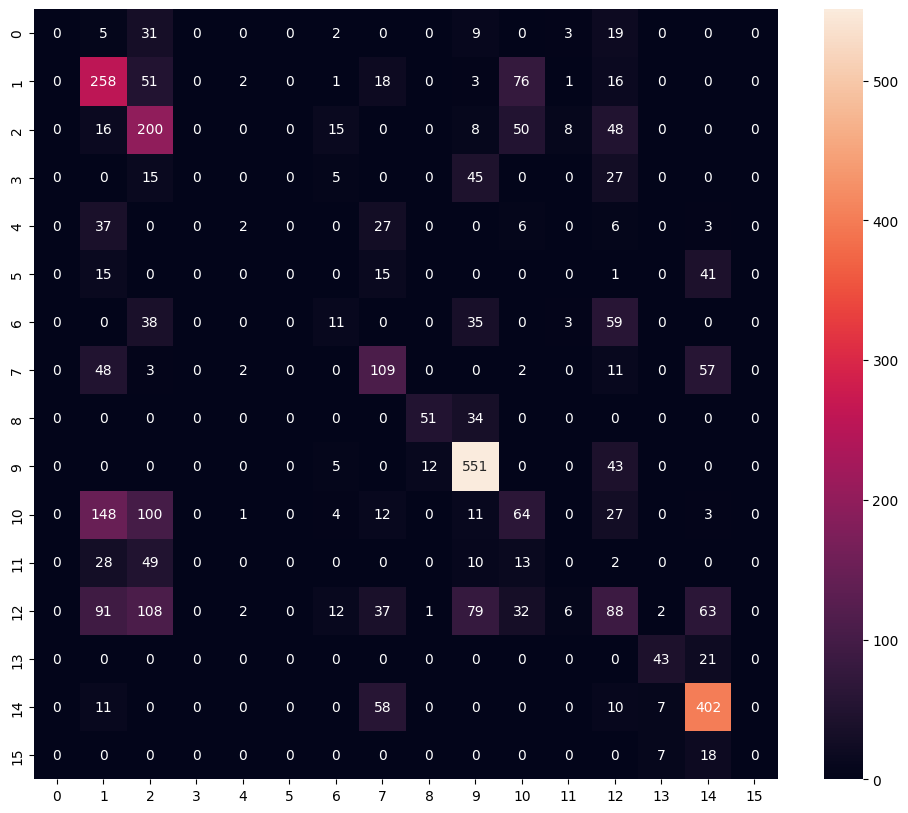

In [252]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(conf_matrix, fmt='g', ax=ax, annot=True)

### Feature importances

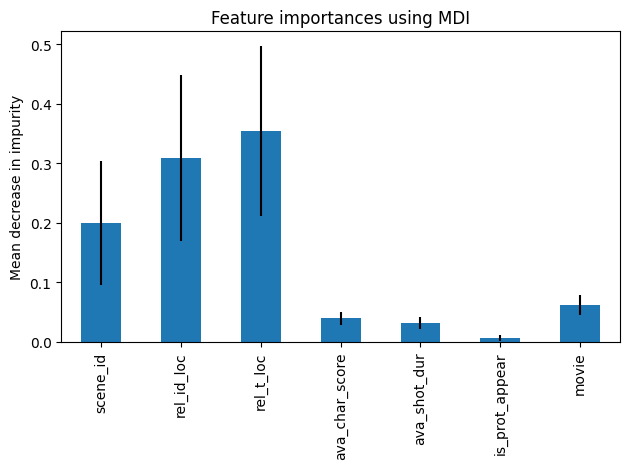

In [253]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

feature_names = [f"feature {i}" for i in range(X.shape[1])]
feature_names = X.columns
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Predict for real test data

In [254]:
# embeddings = np.array(test_full_data['embedding'].tolist())

X = test_full_data[['scene_id', 'rel_id_loc', 'rel_t_loc', 'ava_char_score', 'ava_shot_dur', 'is_prot_appear']]
movie_encoder = LabelEncoder()
X['movie'] = movie_encoder.fit_transform(test_full_data['movie'])
# X = np.hstack((X, embeddings))

y_pred = model.predict(X)

C:\Users\User\AppData\Local\Temp\ipykernel_17364\3029110483.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['movie'] = movie_encoder.fit_transform(test_full_data['movie'])


In [255]:
# print("Shape of X:", X.shape)
# print("Shape of embeddings:", embeddings.shape)
print(y_pred.shape)
print(test_full_data.shape)

(2470,)
(2470, 14)


## Second Model

In [ ]:
from transformers import BertModel, DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

### LabelEncoder

In [ ]:
from sklearn.preprocessing import LabelEncoder

data = []
for movie, scenes in movies_scenes_subtitles.items():
    for scene_number, text in scenes.items():
        data.append({"movie": movie, "scene": scene_number, "text": text})
scenes_df = pd.DataFrame(data)

full_data.insert(full_data.columns.get_loc('label'), 'text', scenes_df['text'])

label_encoder = LabelEncoder()
full_data['encoded_label'] = label_encoder.fit_transform(full_data['label'])

### Train test split

In [ ]:
X = full_data.drop(columns=['movie', 'encoded_label'])
y = full_data['encoded_label']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, random_state=23, test_size=0.3, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, random_state=23, test_size=0.5, stratify=y_temp)

train_texts = X_train['text']
val_texts = X_val['text']
test_texts = X_test['text']

train_labels = y_train
val_labels = y_val
test_labels = y_test


### Tokenizer

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def encode_texts(texts, labels):
    encodings = tokenizer(texts.tolist(), truncation=True, padding=True, return_tensors="pt")
    labels = torch.tensor(labels)
    return encodings, labels

train_encodings, train_labels = encode_texts(train_texts, train_labels.values)
val_encodings, val_labels = encode_texts(val_texts, val_labels.values)
test_encodings, test_labels = encode_texts(test_texts, test_labels.values)

### DataLoader

In [ ]:
train_labels

In [ ]:
train_dataset = TensorDataset(train_encodings['input_ids'], 
                              train_encodings['attention_mask'], 
                              train_labels)
val_dataset = TensorDataset(val_encodings['input_ids'], 
                            val_encodings['attention_mask'], 
                            val_labels)
test_dataset = TensorDataset(test_encodings['input_ids'], 
                             test_encodings['attention_mask'], 
                             test_labels)

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Trening and Validation

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(label_encoder.classes_))
model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

def calculate_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Trening Model
epochs = 12
for epoch in range(epochs):
    model.train()
    total_loss, total_accuracy = 0, 0

    for step, batch in enumerate(train_loader):
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
        
        model.zero_grad()
        b_labels = b_labels.long()
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{epochs} - Loss: {avg_train_loss}')

    # Validation
    model.eval()
    total_eval_accuracy = 0

    for batch in val_loader:
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
        
        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask)
        
        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += calculate_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(val_loader)
    print(f'Epoch {epoch+1}/{epochs} - Validation Accuracy: {avg_val_accuracy}')

print("Training complete")

### Testing Model

In [ ]:
model.eval()
total_test_accuracy = 0

for batch in test_loader:
    b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)

    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask)

    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    total_test_accuracy += calculate_accuracy(logits, label_ids)

avg_test_accuracy = total_test_accuracy / len(test_loader)
print(f'Test Accuracy: {avg_test_accuracy}')

## Third Model

In [193]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

embeddings = np.array(train_full_data['embedding'].tolist())
pca = PCA(n_components=10)
reduced_embeddings = pca.fit_transform(embeddings)

X = train_full_data[['scene_id', 'start', 'end', 'movie', 'rel_id_loc', 'rel_t_loc', 'is_prot_appear']]
label_encoder = LabelEncoder()
movie_encoder = LabelEncoder()
X['movie'] = movie_encoder.fit_transform(train_full_data['movie'])
y = label_encoder.fit_transform(train_full_data['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23, test_size=0.3, stratify=y)

param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'min_child_weight': [1, 2, 4, 6, 8, 10],
    'gamma': [0.1, 0.3, 0.5, 0.7, 1.0, 1.5, 2],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}


xgb = XGBClassifier(random_state=23)

random_search = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=10, cv=5, random_state=23, n_jobs=-1)
random_search.fit(X, y)

print("Best parameters:", random_search.best_params_)

C:\Users\User\AppData\Local\Temp\ipykernel_17364\1546538747.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['movie'] = movie_encoder.fit_transform(train_full_data['movie'])


Best parameters: {'subsample': 0.6, 'n_estimators': 300, 'min_child_weight': 6, 'max_depth': 9, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.9}


In [194]:
best_params = random_search.best_params_
model = XGBClassifier(**best_params, random_state=23)
model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [183]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy:", accuracy)
print(classification_report(y_test, y_pred))


Accuracy: 0.6210902591599643
              precision    recall  f1-score   support

           0       0.57      0.19      0.29        21
           1       0.60      0.58      0.59       128
           2       0.58      0.62      0.60       104
           3       0.54      0.50      0.52        28
           4       0.60      0.50      0.55        24
           5       0.70      0.32      0.44        22
           6       0.57      0.66      0.61        44
           7       0.65      0.66      0.65        70
           8       0.74      0.68      0.71        25
           9       0.87      0.90      0.88       183
          10       0.46      0.46      0.46       111
          11       0.50      0.29      0.37        31
          12       0.38      0.41      0.39       156
          13       0.78      0.74      0.76        19
          14       0.75      0.85      0.80       146
          15       0.40      0.29      0.33         7

    accuracy                           0.62      1


Confusion Matrix:


<Axes: >

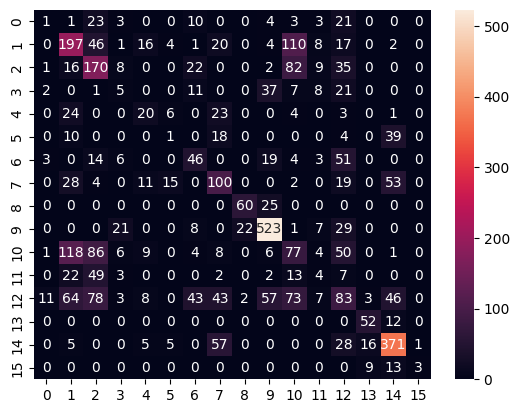

In [188]:
import seaborn as sns
import matplotlib.pyplot as plt

predicted = cross_val_predict(model, X, y, cv=5)
conf_matrix = confusion_matrix(y, predicted)

print("\nConfusion Matrix:")
sns.heatmap(conf_matrix, annot=True, fmt='g')

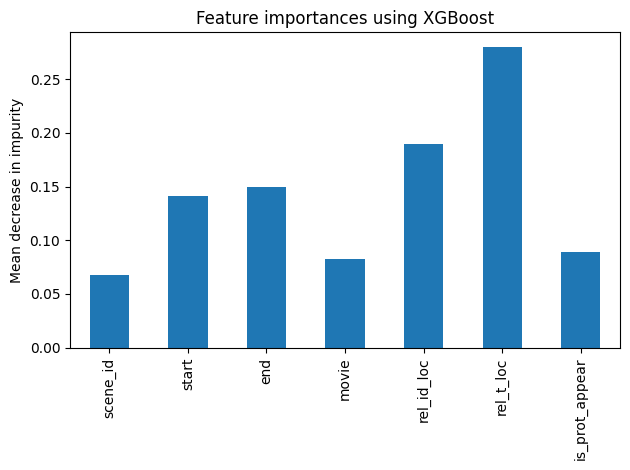

In [189]:
importances = model.feature_importances_
feature_names = X.columns
# feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using XGBoost")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

plt.show()

In [195]:
X = test_full_data[['scene_id', 'start', 'end', 'movie', 'rel_id_loc', 'rel_t_loc', 'is_prot_appear']]
X['movie'] = movie_encoder.fit_transform(test_full_data['movie'])
y_pred = model.predict(X)
y_pred_labels = label_encoder.inverse_transform(y_pred)
print(y_pred_labels.shape)
print(test_full_data.shape)

(2470,)
(2470, 14)


C:\Users\User\AppData\Local\Temp\ipykernel_17364\3314366978.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['movie'] = movie_encoder.fit_transform(test_full_data['movie'])


## Text classification using BERT (Fourth Model)

### Helper functions

In [314]:
unique_labels = train_full_data['label'].unique()
label_to_int_mapping = {label: i for i, label in enumerate(unique_labels)}
int_to_label_mapping = {i: label for label, i in label_to_int_mapping.items()}

def map_label_to_int(label):
    return label_to_int_mapping[label]


def map_label_from_int(label):
    return int_to_label_mapping[label] 

In [315]:
def transform_subtitles(subtitles, df):
    transformed_subtitles = []
    for movie_name, scenes in subtitles.items():
        for scene_id, text in scenes.items():
            # Get the label from train_full_data based on movie and scene_id
            label = df[(df['movie'] == movie_name) & (df['scene_id'] == scene_id)]['label'].values[0]
            label = map_label_to_int(label)
            
            result = {'text': text, 'label': label}
            transformed_subtitles.append(result)
    
    return transformed_subtitles


def transform_validation_subtitles(subtitles, df):
    transformed_subtitles = []
    for movie_name, scenes in subtitles.items():
        for scene_id, text in scenes.items():
            result = {'text': text}
            transformed_subtitles.append(result)
    
    return transformed_subtitles
    

def print_head_transformed_subtitles(subtiltes):
    for i in range(min(5, len(subtiltes))):
        print(subtiltes[i])

In [312]:
train_subtitles = associate_scenes_with_subtitles_extra_info(train_full_data, train_movie_subtitles, train_movie_scenes_count)
clean_train_subtitles = clean_subtitles_only_words(train_subtitles)
train_transformed_subtitles = transform_subtitles(clean_train_subtitles, train_full_data)

Ignored subtitltes: 3018


In [313]:
train_transformed_subtitles

[{'text': "sceneStart0 sceneEnd219 sceneId0 sceneMoviePercentage0 You'd better take this along Don It's gonna be cold on the farm  OK  How many shirts are you taking  Three  I'm taking five  Five  Yeah I told them at the office I might not be back until Tuesday We'll get there this afternoon That's Friday Saturday Sunday Monday We'll make it a long wonderful weekend Sounds long all right It'll be good for you Don after what you've been through Trees grass sweet cider and buttermilk and water from that well that's colder than any other Wick please Why this emphasis on liquids Very dull liquids Sorry Don I think it'd be a good idea if we took along my typewriter  What for  To write I'm gonna write there get started on that novel  You really feel up to writing  Why not After what you've been through I haven't touched the stuff for 10 days now I know I know you haven't Don  Where is the typewriter  In the living room In the closet Kind of towards the back",
  'label': 0},
 {'text': "sceneS

In [317]:
validation_subtitles = associate_scenes_with_subtitles_extra_info(test_full_data, test_movie_subtitles, test_movie_scenes_count)
clean_validation_subtitles = clean_subtitles_only_words(validation_subtitles)
validation_transformed_subtitles = transform_validation_subtitles(clean_validation_movies_scenes_subtitles, test_full_data)

Ignored subtitltes: 3165


In [318]:
from sklearn.model_selection import train_test_split

# Extract 'text' and 'label' from each dictionary
texts = [item['text'] for item in train_transformed_subtitles]
labels = [item['label'] for item in train_transformed_subtitles]

# Split the data into training and testing sets (80% training, 20% testing)
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.3, random_state=42)

# # Create training and testing datasets
train_data = [{'text': text, 'label': label} for text, label in zip(train_texts, train_labels)]
test_data = [{'text': text, 'label': label} for text, label in zip(test_texts, test_labels)]

In [319]:
from datasets import Dataset
train_dataset = Dataset.from_list(train_data)
test_dataset = Dataset.from_list(test_data)
validation_dataset = Dataset.from_list(validation_transformed_subtitles)

print(train_dataset)
print(test_dataset)
print(validation_dataset)

Dataset({
    features: ['text', 'label'],
    num_rows: 2610
})
Dataset({
    features: ['text', 'label'],
    num_rows: 1119
})
Dataset({
    features: ['text'],
    num_rows: 2470
})


In [320]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoTokenizer

def choose_model(name):
    if name == "distilbert": 
        tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
        model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=16)
    elif name == "bert":
        tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
        model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=16)
    elif name == "roberta":
        tokenizer = AutoTokenizer.from_pretrained("roberta-base")
        model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=16)
    else:
        tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
        model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=16)

choose_model("roberta")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [321]:
import nltk
from nltk.corpus import stopwords

# nltk.download('stopwords')

In [322]:
# print(stop_words)

In [323]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

def preprocess_function(examples):
    examples["text"] = [remove_stopwords(text) for text in examples["text"]]
    tokenized_text = tokenizer(examples["text"], truncation=True)
    
    return tokenized_text

In [324]:
tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True)
tokenized_train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True)
tokenized_test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

tokenized_validation_dataset = validation_dataset.map(preprocess_function, batched=True)
tokenized_validation_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])

Map:   0%|          | 0/2610 [00:00<?, ? examples/s]

Map:   0%|          | 0/1119 [00:00<?, ? examples/s]

Map:   0%|          | 0/2470 [00:00<?, ? examples/s]

In [325]:
tokenized_test_dataset

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 1119
})

In [326]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [327]:
import evaluate
metric = evaluate.load('accuracy')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    return metric.compute(predictions=predictions, references=labels)

In [329]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    num_train_epochs=25,
    weight_decay=0.01,
    logging_steps=100
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

Step,Training Loss
100,0.726600
200,0.694900
300,0.652500
400,0.528100
500,0.530500
600,0.479400
700,0.489800
800,0.450700
900,0.380400
1000,0.371200


Checkpoint destination directory ./results\checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results\checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results\checkpoint-1500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=4075, training_loss=0.23917465490797546, metrics={'train_runtime': 41184.3312, 'train_samples_per_second': 1.584, 'train_steps_per_second': 0.099, 'total_flos': 2453416519334592.0, 'train_loss': 0.23917465490797546, 'epoch': 24.92})

In [330]:
trainer.evaluate()

{'eval_loss': 3.1284310817718506,
 'eval_accuracy': 0.450402144772118,
 'eval_runtime': 32.1625,
 'eval_samples_per_second': 34.792,
 'eval_steps_per_second': 4.353,
 'epoch': 24.92}

In [331]:
predictions = trainer.predict(tokenized_validation_dataset)

In [333]:
predicted_probabilities = predictions.predictions
predicted_label_ids = np.argmax(predicted_probabilities, axis=-1)

label_predictions = [map_label_from_int(label) for label in predicted_label_ids]
print(f"first 5 predictions: {label_predictions[:10]} \nlast 5 predictions: {label_predictions[-10:]}")

first 5 predictions: ['Opening Image', 'Set-Up', 'Set-Up', 'Set-Up', 'Set-Up', 'Set-Up', 'Set-Up', 'Set-Up', 'Set-Up', 'Set-Up'] 
last 5 predictions: ['Finale', 'Finale', 'Finale', 'Finale', 'Finale', 'Finale', 'Finale', 'Finale', 'Finale', 'Finale']


## Result data

In [334]:
result_df = pd.DataFrame(columns=['Id', 'Label'])

def fill_result_df(full_data, movies, movies_ids, predictions):
    for idx, scene in full_data.iterrows():
        movie_name = scene['movie']
        movie_index = movies.index(movie_name)
        movie_id = movies_ids[movie_index]
        scene_id = scene['scene_id']
        movie_scene_id = f"{movie_id}_{scene_id}"

        pred_label = predictions[idx]
        result_df.loc[idx] = [movie_scene_id, pred_label]

In [335]:
# Fourth model
fill_result_df(test_full_data, test_movies, test_movies_ids, label_predictions)
# First model
# fill_result_df(test_full_data, test_movies, test_movies_ids, y_pred_labels)

result_df.head()

,Id,Label
0,tt0822832_1,Opening Image
1,tt0822832_2,Set-Up
2,tt0822832_4,Set-Up
3,tt0822832_6,Set-Up
4,tt0822832_7,Set-Up


In [336]:
result_df.to_csv('output_robert.csv', index=False)

## Clean memory

In [64]:
import torch
torch.cuda.empty_cache()

In [65]:
import gc
gc.collect()

1120

## Save combined clean data in file

In [203]:
output_file_path = "output_combined_file.txt"  # Set your desired output file

with open(output_file_path, 'w', encoding='utf-8') as output_file:
    for movie, scenes in clean_train_movies_scenes_subtitles.items():
        output_file.write(f"======= {movie} =========\n\n")
        output_file.write(str(scenes))

print("Combined text file saved successfully.")


Combined text file saved successfully.


In [202]:
output_file_path = "output_combined_file2.txt"  # Set your desired output file

with open(output_file_path, 'w', encoding='utf-8') as output_file:
    for movie, scenes in clean_train_subtitles.items():
        output_file.write(f"======= {movie} =========\n\n")
        output_file.write(str(scenes))

print("Combined text file saved successfully.")


Combined text file saved successfully.
